In [1]:
import cv2 
import numpy as np
import mediapipe as mp 
import matplotlib.pyplot as plt 

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [3]:
path1 = "/home/anindya/Documents/Github/YogaPosGNN/videos/video2.mkv"
path2 = '/home/anindya/Documents/Atelta/AteltaWebStream/RawData/UnderTheInfluenceChoreo.mp4'

In [4]:
def get_image_instance(video_path, instance=1000):
    cap = cv2.VideoCapture(video_path)
    counter = 0

    while True:
        counter += 1
        ret, frame = cap.read() 
        if counter > instance : break 
    return frame 

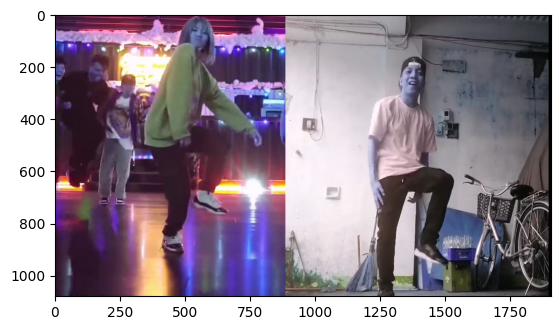

In [5]:
vid1_instance = get_image_instance(path1, 620)
plt.imshow(vid1_instance)

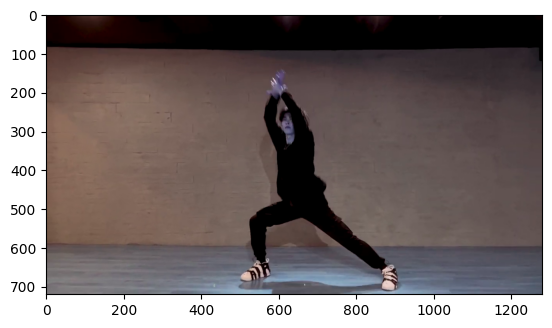

In [12]:
vid2_instance = get_image_instance(path2, 620)
plt.imshow(vid2_instance)

In [13]:
# seperating teacher and actor

inst_11, inst_12 = vid1_instance[:, :750, :], vid1_instance[:, 890:, :]

In [14]:
def predict_on_image(image):
    BG_COLOR = (192, 192, 192) # gray
    with mp_pose.Pose(static_image_mode=True, 
                      model_complexity=2, 
                      enable_segmentation=False, min_detection_confidence=0.28) as pose:
        
        image_height, image_width, _ = image.shape
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if not results.pose_landmarks:
            return None, None
        print(
            f'Nose coordinates: ('
            f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
            f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
        )

        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        # Plot pose world landmarks.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    return annotated_image, results

Nose coordinates: (552.4471253156662, 88.75345945358276)


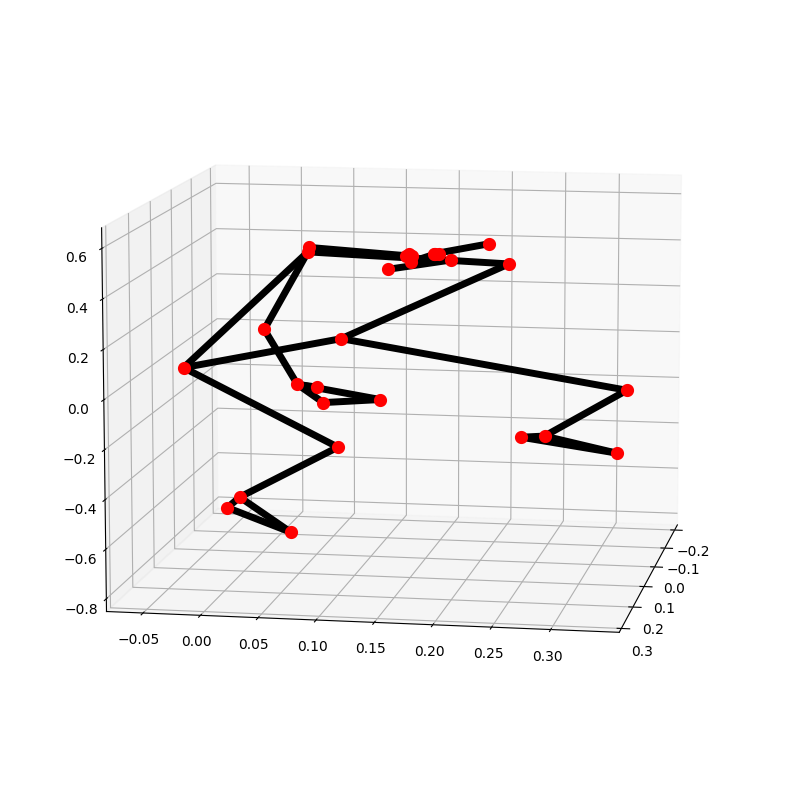

In [15]:
inst_11_annotated, inst11_result = predict_on_image(inst_11)

Nose coordinates: (492.4090790748596, 246.39499425888062)


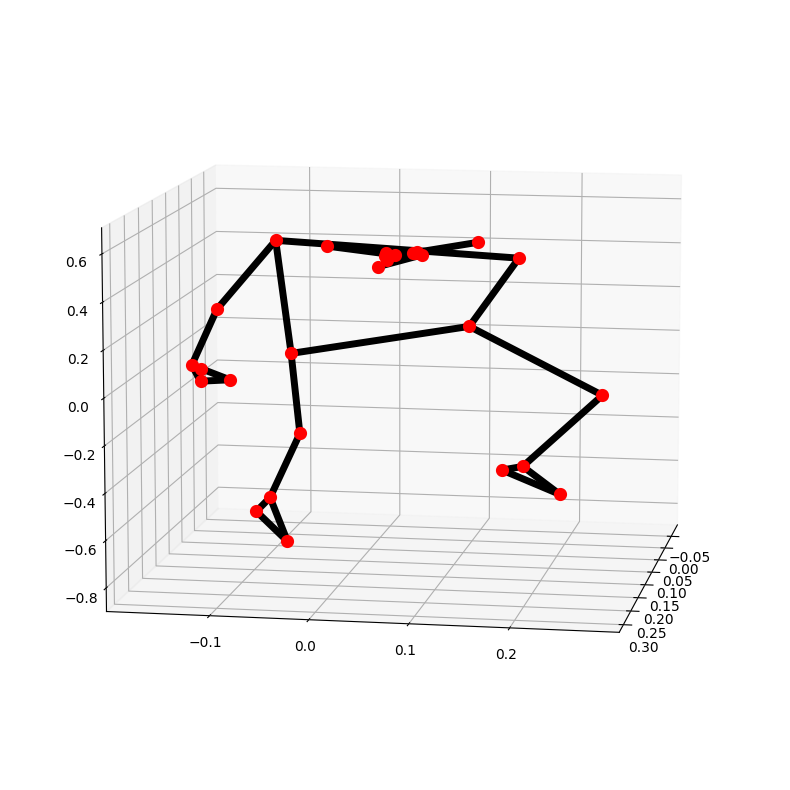

In [16]:
inst_12_annotated, inst12_result = predict_on_image(inst_12)

Nose coordinates: (624.8737335205078, 287.290678024292)


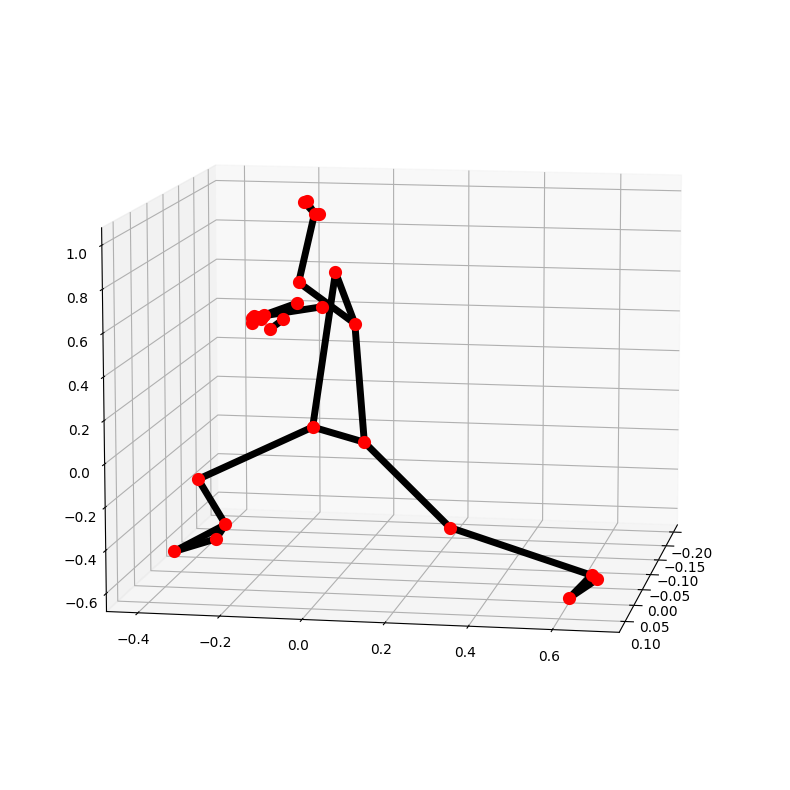

In [17]:
inst_2_annotated, inst_2_result = predict_on_image(vid2_instance)

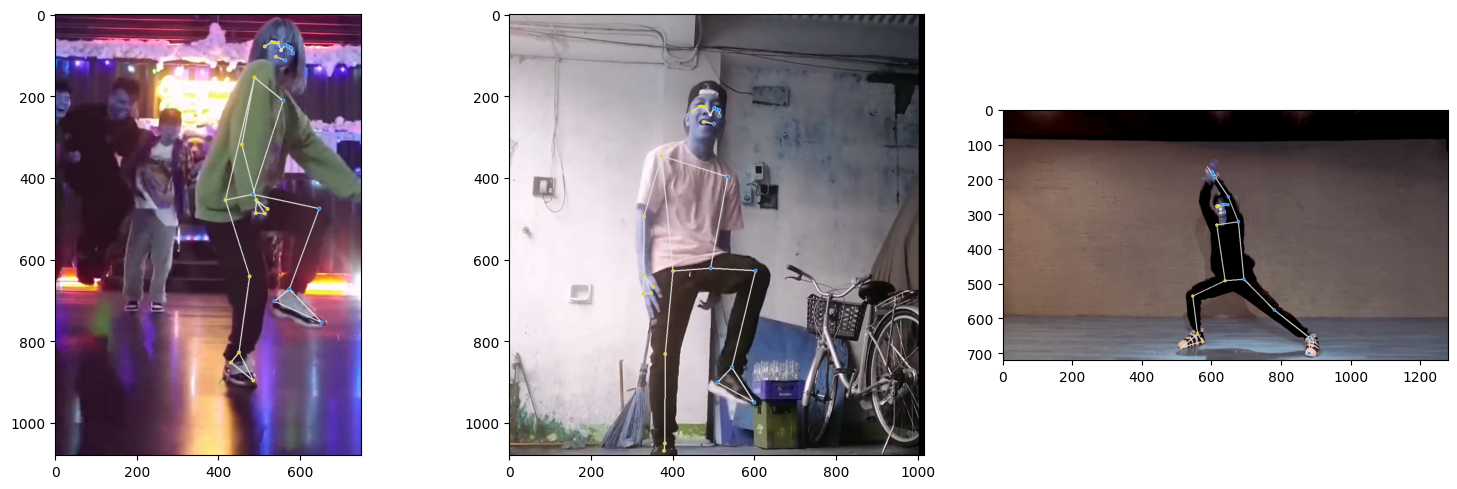

In [18]:
import numpy as np
import matplotlib.pyplot as plt

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)
y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].imshow(inst_11_annotated)
axes[1].imshow(inst_12_annotated)
axes[2].imshow(inst_2_annotated)

fig.tight_layout()

### Custom landmark

In [19]:
import cv2
import math


def draw_custom_landmark(
    image,
    results,
    connection,
    mask_background=False,
    result_conversion=True,
    indices_to_avoid_nodes=None,
    indices_to_avoid_edges=None,
    dot_color=(0, 255, 0),
    line_color=(0, 0, 255),
    diameter=6,
    line_width=3,
):
    """
    image : numpy.ndarray,
    landmarks : mediapipe_landmarks.landmark,
    indices_to_avoid_nodes : the indices to avoid during drawing for the nodes,
    indices_to_avoid_edges : the indices to avoid during drawing for the edges,
    dot_color : the color of the nodes,
    line_color : the color of the edges,
    diameter : the diameter of the circle of the nodes,
    line_width : the width of the circle
    """
    # TODO : draw a trivial edge as a hand to palm joint
    # TODO : Have to make compatible with multi landmarks, though it could be done explicitely

    height, width, _ = image.shape
    connection = list(connection)
    
    if mask_background:
        image = np.zeros_like(image)
        
    if result_conversion:
        landmarks = []
        for landmark in results.pose_landmarks.landmark:
            landmarks.append((landmark.x, landmark.y))
    else:
        landmarks = results

    keypoints = []

    for idx, landmark in enumerate(landmarks):
        x, y = landmark

        x_px = int(min(math.floor(x * width), width - 1))
        y_px = int(min(math.floor(y * height), height - 1))
        keypoints.append((x_px, y_px))

        if indices_to_avoid_nodes is not None and idx in indices_to_avoid_nodes:
            continue

        else:
            cv2.circle(image, (int(x_px), int(y_px)), diameter, dot_color, -1)

    for inx, conn in enumerate(connection):
        from_ = conn[0]
        to_ = conn[1]
        if indices_to_avoid_edges is not None and from_ in indices_to_avoid_edges:
            continue
        else:
            if keypoints[from_] and keypoints[to_]:
                cv2.line(image, keypoints[from_], keypoints[to_], line_color, line_width)
            else:
                continue
    return image

In [22]:
def convert_results_to_numpy(results):
    landmarks = []

    for landmark in results.pose_landmarks.landmark:
        landmarks.append((landmark.x, landmark.y))
    
    return np.array(landmarks)

In [68]:
from typing import List, Union, Tuple


def draw_keypoints(image: np.ndarray, 
                   landmarks: Union[list, np.ndarray], connection: List[Tuple[int, int]], 
                   dot_color: Tuple[int, int, int], line_color: Tuple[int, int,int], 
                   diameter=6,line_width=3) -> None:
    height, width, _ = image.shape
    
    keypoints = []
    for idx, landmark in enumerate(landmarks):
        x, y = landmark

        x_px = int(min(math.floor((x * width) + width//2), width - 1))
        y_px = int(min(math.floor((y * height) + height//2), height - 1))
        keypoints.append((x_px, y_px))
        cv2.circle(image, (int(x_px), int(y_px)), diameter, dot_color, -1)
    
    for inx, conn in enumerate(connection):
        from_ = conn[0]
        to_ = conn[1]
    
        if keypoints[from_] and keypoints[to_]:
            cv2.line(image, keypoints[from_], keypoints[to_], line_color, line_width)
        else:
            continue
    return image 
    
    

def draw_landmarks_from_landmark(landmarks_list : List[np.ndarray], dot_colors: List[Tuple[int, int, int]], 
                                 line_colors: Tuple[int, int, int], canvas_shape = (750, 1080, 3)) -> None:
    
    canvas = np.zeros(canvas_shape, dtype=np.uint8)
    for landmarks, dot_color, line_color in zip(landmarks_list, dot_colors, line_colors):
        canvas = draw_keypoints(canvas, 
                                landmarks, 
                                connection=mp_pose.POSE_CONNECTIONS, 
                                dot_color=dot_color, line_color=line_color)
    plt.imshow(canvas)

In [69]:
img = draw_custom_landmark(
    inst_11, results=inst11_result, 
    mask_background=True,
    connection=mp_pose.POSE_CONNECTIONS
)

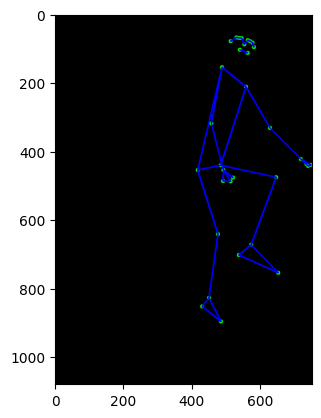

In [70]:
plt.imshow(img)

### Landmark alignment

In [55]:
landmark11 = convert_results_to_numpy(inst11_result)
landmark12 = convert_results_to_numpy(inst12_result)
landmark2 = convert_results_to_numpy(inst_2_result)

In [56]:
from scipy.spatial import procrustes

In [57]:
scaled_keypoints_11, sk11, _ = procrustes(landmark11, landmark12)
scaled_keypoints_12, sk12, _ = procrustes(landmark12, landmark11)

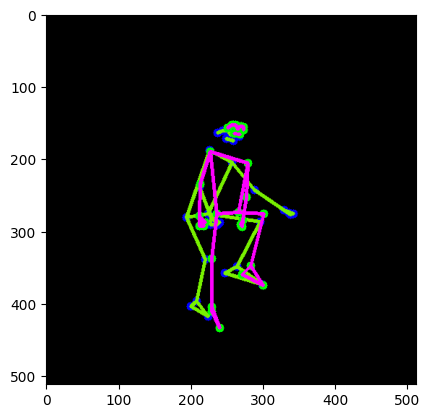

In [71]:
### DRAWING ONLY THE SCALED LANDMARK 

draw_landmarks_from_landmark(
    landmarks_list=[scaled_keypoints_11, scaled_keypoints_12], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
    canvas_shape=(512, 512, 3)
)

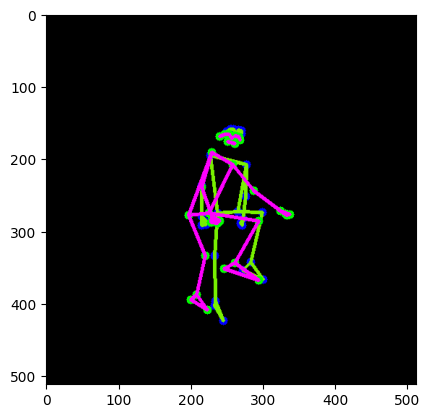

In [59]:
### DRAWING ONLY THE SCALED LANDMARK 

draw_landmarks_from_landmark(
    landmarks_list=[sk11, sk12], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
    canvas_shape=(512, 512, 3)
)

In [60]:
### ALIGNING THE KEYPOINTS 

aligned_keypoints_11, _, _ = procrustes(scaled_keypoints_11, scaled_keypoints_12)
aligned_keypoints_12, _, _ = procrustes(scaled_keypoints_12,  scaled_keypoints_11)

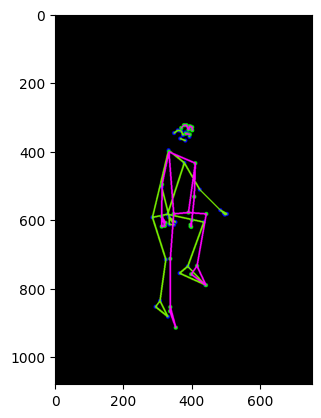

In [66]:
draw_landmarks_from_landmark(
    landmarks_list=[aligned_keypoints_11, aligned_keypoints_12], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
)

### For second image

In [62]:
scaled_keypoints_11_1, _, _ = procrustes(landmark11, landmark2)
scaled_keypoints_2_11, _, _ = procrustes(landmark2, landmark11)

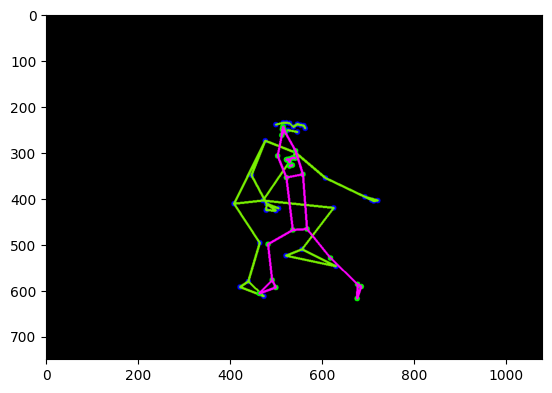

In [72]:
draw_landmarks_from_landmark(
    landmarks_list=[scaled_keypoints_11_1, scaled_keypoints_2_11], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
)

In [64]:
aligned_keypoints_11_1, _, _ = procrustes(scaled_keypoints_11_1, scaled_keypoints_2_11)
aligned_keypoints_2_11, _, _ = procrustes(scaled_keypoints_2_11, scaled_keypoints_11_1)

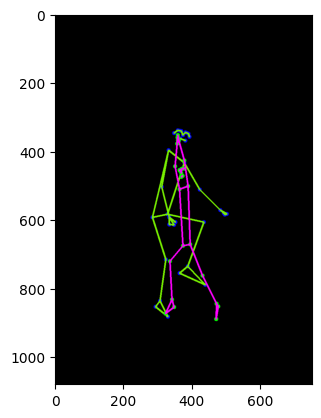

In [67]:
draw_landmarks_from_landmark(
    landmarks_list=[aligned_keypoints_11_1, aligned_keypoints_2_11], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
)